In [2]:
import keras_cv
import tensorflow as tf
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import keras
import cv2

In [5]:
os.mkdir('images')
os.chdir(os.path.join(os.getcwd(),'images'))

In [6]:
path_to_img="D:\PCB\images"
import splitfolders
input_folder =path_to_img
output="D:\PCB\PCB_USED"
splitfolders.ratio(input_folder, output=output, ratio=(.6, .2, .2))


Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  2.77 files/s]
Copying files: 8 files [00:00, 21.67 files/s]
Copying files: 15 files [00:00, 35.31 files/s]
Copying files: 23 files [00:00, 47.95 files/s]
Copying files: 30 files [00:00, 51.83 files/s]
Copying files: 38 files [00:00, 59.21 files/s]
Copying files: 46 files [00:01, 63.12 files/s]
Copying files: 53 files [00:01, 60.97 files/s]
Copying files: 60 files [00:01, 60.87 files/s]
Copying files: 67 files [00:01, 50.71 files/s]
Copying files: 73 files [00:01, 46.67 files/s]
Copying files: 79 files [00:01, 48.08 files/s]
Copying files: 86 files [00:01, 52.51 files/s]
Copying files: 92 files [00:01, 54.07 files/s]
Copying files: 98 files [00:02, 55.34 files/s]
Copying files: 104 files [00:02, 56.31 files/s]
Copying files: 111 files [00:02, 57.69 files/s]
Copying files: 117 files [00:02, 57.73 files/s]
Copying files: 124 files [00:02, 59.67 files/s]
Copying files: 131 files [00:02, 56.19 files/s]
Copying files:

In [54]:
import tensorflow as tf
import pathlib

def image_generator(image_dir):
    image_dir = pathlib.Path(image_dir)
    image_paths = list(image_dir.glob('*/*.jpg'))  # Adjust the file pattern if needed
    image_paths = [str(path) for path in image_paths]
    
    for image_path in image_paths:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        yield image

image_dir ="D:\PCB\images"
image_dataset = tf.data.Dataset.from_generator(
    lambda: image_generator(image_dir),
    output_signature=tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8)
)


In [57]:
import tensorflow as tf
import os

image_dir = 'D:/PCB/images'

def image_generator(image_dir):
    # Iterate over the images in the directory
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(image_dir, filename)
            # Load and preprocess the image
            image = tf.io.read_file(image_path)
            image = tf.image.decode_image(image)
            # Yield the image
            yield image

# Create a dataset from the image generator
image_dataset = tf.data.Dataset.from_generator(
    lambda: image_generator(image_dir),
    output_signature=tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8)
)

# Print the first few elements of the dataset
for image in image_dataset.take(5):
    print(image.shape)


In [59]:
# Step 1: Load your dataset
dataset = builder.as_dataset(as_supervised=True)

# Step 2: Convert the dataset to a list for splitting
data_list = list(dataset)

train_size = 7087
test_size = 1772

train_data = data_list[:train_size]
test_data = data_list[train_size:train_size+test_size]
val_data = data_list[train_size+test_size:]

# Optionally, you can convert the split data back to a TensorFlow dataset if needed
images_train = tf.data.Dataset.from_tensor_slices(train_data)
images_test = tf.data.Dataset.from_tensor_slices(test_data)
images_val = tf.data.Dataset.from_tensor_slices(val_data)


In [60]:
tfds.show_examples(images_train, builder.info)

<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

In [61]:
#A function to perform the necessary data preprocessing steps 
def prepare_data(images, labels):
    labels = tf.one_hot(labels,6)
    images = tf.image.resize(images, (1500, 1500))
    images=tf.image.convert_image_dtype(images, tf.float32)
    print('conversions done')
    inputs = {"images": images, "labels": labels}
    return inputs

# Augmentation

Let's Augment the dataset using Keras_CV.

Let us begin by defining an Augmenter

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming your dictionary is called `data_dict`
# Convert the dictionary values to a NumPy array
images_train = np.array(list(inputs.values()))

# Create an instance of ImageDataGenerator with desired augmentation parameters
data_generator = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply augmentation to your dataset
augmented_images_train = data_generator.flow(images_train, batch_size=16)


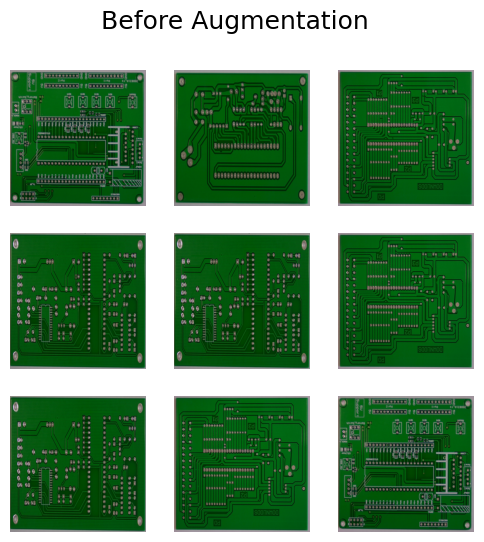

In [12]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()
visualize_dataset(images_train, title="Before Augmentation")

In [13]:
images_train_aug = images_train.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
images_test_aug = images_test.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
images_val_aug = images_val.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

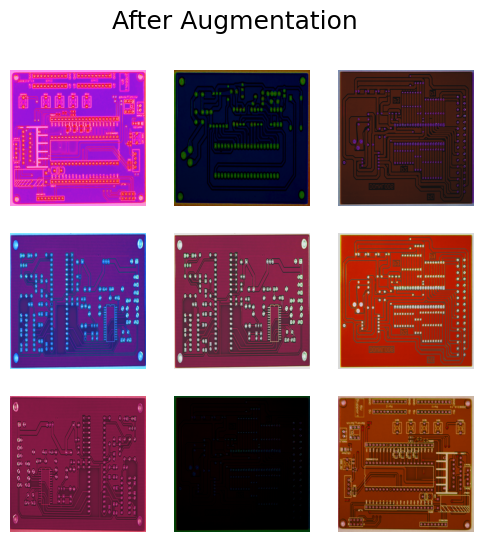

In [14]:
visualize_dataset(images_train_aug, title="After Augmentation")

In [15]:
effnet = keras_cv.models.EfficientNetV2B1(include_rescaling=False,
                                          include_top=False,
                                          input_shape=(1500, 1500, 3),
                                          weights="imagenet/classification-v0")
effnet.trainable=False
model=tf.keras.models.Sequential()
model.add(keras.Input(shape=(1500, 1500, 3)))
model.add(effnet)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(6))
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model.summary()

28156960/28156960 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 47, 47, 1280)      6931124   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 6,938,810
Trainable params: 7,686
Non-trainable params: 6,931,124
_________________________________________________________________


In [16]:
def prep_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

In [17]:
def prep_for_model_val(inputs):
    images = inputs["images"]
    images = tf.cast(images, tf.float32)
    return images

In [25]:
train_dataset=images_train.map(prep_for_model)
test_dataset=images_test.map(prep_for_model)
val_dataset=images_val.map(prep_for_model)

In [19]:
callbacks=tf.keras.callbacks.EarlyStopping(min_delta=0.0005,patience=3)
history=model.fit(train_dataset,validation_data=test_dataset,epochs=30,callbacks=[callbacks])

Epoch 1/30


2023-04-02 04:40:23.253978: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/model/block1b_/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


26/26 [==============================] - 55s 2s/step - loss: 6.3923 - accuracy: 0.1667 - val_loss: 5.2954 - val_accuracy: 0.1773
Epoch 2/30
26/26 [==============================] - 56s 2s/step - loss: 6.1652 - accuracy: 0.1715 - val_loss: 5.1501 - val_accuracy: 0.1702
Epoch 3/30
26/26 [==============================] - 39s 2s/step - loss: 6.3388 - accuracy: 0.1667 - val_loss: 5.6686 - val_accuracy: 0.1702
Epoch 4/30
26/26 [==============================] - 39s 2s/step - loss: 6.6692 - accuracy: 0.1329 - val_loss: 4.9155 - val_accuracy: 0.1702
Epoch 5/30
26/26 [==============================] - 41s 2s/step - loss: 6.0446 - accuracy: 0.1787 - val_loss: 4.6655 - val_accuracy: 0.1631
Epoch 6/30
26/26 [==============================] - 46s 2s/step - loss: 5.8347 - accuracy: 0.1691 - val_loss: 3.5184 - val_accuracy: 0.1418
Epoch 7/30
26/26 [==============================] - 39s 2s/step - loss: 4.9093 - accuracy: 0.1643 - val_loss: 1.8286 - val_accuracy: 0.1702
Epoch 8/30
26/26 [=============

<AxesSubplot:>

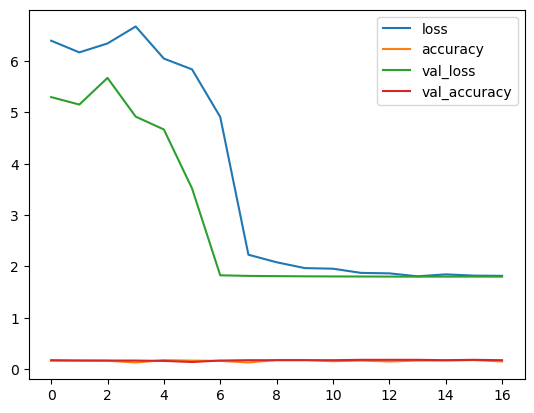

In [20]:
import pandas as pd
history=pd.DataFrame(history.history)
history.plot()

In [26]:
model.evaluate(val_dataset)

138/138 [==============================] - 11s 77ms/step - loss: 1.8034 - accuracy: 0.1667


[1.8034417629241943, 0.1666666716337204]